# Objective

The objective of this projection is to predict the healthcare cost of a charter school network for 2026 and 2026 to appropiately allocate funds in the budget based on healthcare expenses from 2019-2025. Healthcare cost are dependent on the number of employees employeed at the organization.

In [1]:
# importing packages
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from statsmodels.formula.api import ols

In [2]:
# importing data
df = pd.read_csv(r'/Users/scipio/Downloads/FY Health Care Costs - FY Healthcare Cost.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7 entries, 0 to 6
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   FY         7 non-null      int64  
 1   Employees  7 non-null      int64  
 2   Expenses   7 non-null      float64
dtypes: float64(1), int64(2)
memory usage: 296.0 bytes


In [4]:
# Data Cleaning
mil = 10**6 # <- creating variable equal to 1 million

df['Expenses'] = df['Expenses']/mil # <- number abbreviation
df.rename(columns = {'Expenses':'Expenses_Mil'}, inplace = True) # <- renaming column

In [5]:
# Statistical Metrics
round(df['Expenses_Mil'].describe(),2)

count    7.00
mean     2.28
std      0.46
min      1.83
25%      1.98
50%      2.02
75%      2.56
max      3.02
Name: Expenses_Mil, dtype: float64

In [6]:
# displaying data
print(df)

     FY  Employees  Expenses_Mil
0  2019        135      1.977209
1  2020        142      2.024875
2  2021        157      1.988532
3  2022        183      1.833999
4  2023        181      2.319670
5  2024        177      2.799097
6  2025        205      3.024000


In [7]:
_25 = round(df['Expenses_Mil'].quantile(.25),2)
_75 = round(df['Expenses_Mil'].quantile(.75),2)
IQR = _75 - _25

Upper_Outlier = _75 + (1.5 * IQR)
Lower_Outlier = _25 - (1.5 * IQR)

print('An outlier in the dataset is any value greater than or eqaul to',
      f"${round(Upper_Outlier * mil,2):,}",'or less than or equal to',f"${round(Lower_Outlier * mil,2):,}",
     '. There are',df[(df['Expenses_Mil']>= Upper_Outlier)|(df['Expenses_Mil'] <= Lower_Outlier)].shape[0],
      'outliers in the dataset.')

An outlier in the dataset is any value greater than or eqaul to $3,430,000.0 or less than or equal to $1,110,000.0 . There are 0 outliers in the dataset.


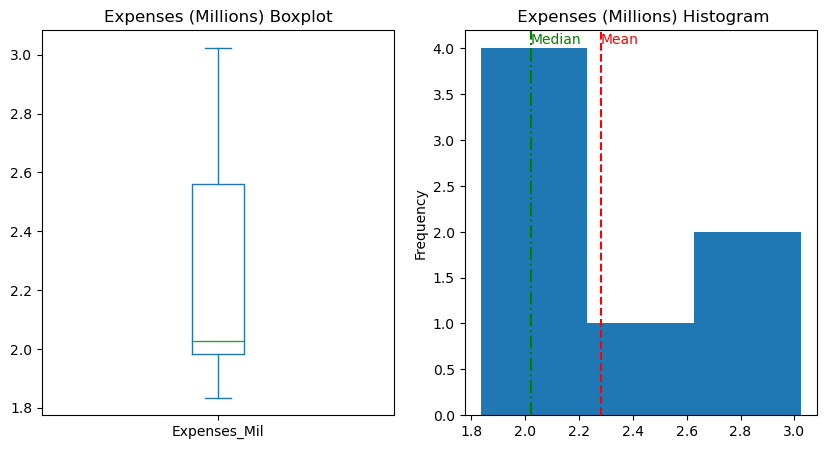

In [8]:
mean = round(df['Expenses_Mil'].mean(),2)
median = round(df['Expenses_Mil'].median(),2)

fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (10,5))

df['Expenses_Mil'].plot(kind = 'box', ax = ax[0], title = 'Expenses (Millions) Boxplot',)
df['Expenses_Mil'].plot(kind = 'hist', ax = ax[1], title = ' Expenses (Millions) Histogram', bins = 3 )
ax[1].axvline(x = mean, color = 'red', linestyle = '--' ) # <- plotting mean on histogram
ax[1].axvline(x = median, color = 'green', linestyle = '-.') # <- plotting median on histogram
ax[1].text(2.28,4.05,'Mean', color = 'red')
ax[1].text(2.02,4.05 ,'Median', color = 'green')

plt.show()

Based on the histogram, there is a right skew in the dataset as the mean is higher than the median. Additionally, the medical expense for 2023 is considered to be an outlier.

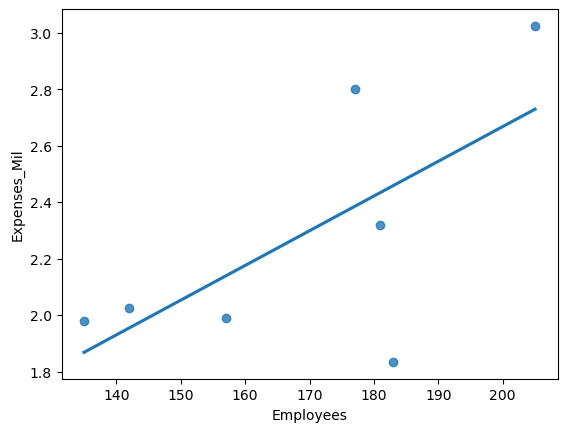

In [9]:
# Plotting Data

plt.figure() # <- creating figure

sns.regplot(x = 'Employees', y = 'Expenses_Mil', ci = None, data = df) # <- Linear Regression

plt.show() # <- displaying data

In [10]:
# Creaitng data model
mdl_health_expenses = ols('Expenses_Mil~Employees',data = df) # <- Creating model
mdl_health_expenses = mdl_health_expenses.fit() # <- fitting model
print(mdl_health_expenses.params) # <- printing model parameters

Intercept    0.207537
Employees    0.012301
dtype: float64


In [11]:
# Leverage and Influence
summary_healthcare = mdl_health_expenses.get_influence().summary_frame()

"""
Leverage indicates how extreme explanatory variables are.
Influence measures the impact a single point would have on a model.
In both cases the higher the value, the greater the influence.
"""

df['Leverage'] = summary_healthcare['hat_diag'] # <- inserting leverage measurement 
df['Influence'] = summary_healthcare['cooks_d'] # <- inserting influence measurement
print (df.sort_values(by = 'Influence', ascending = False))

     FY  Employees  Expenses_Mil  Leverage  Influence
6  2025        205      3.024000  0.498850   0.615680
3  2022        183      1.833999  0.198705   0.430368
5  2024        177      2.799097  0.161915   0.141118
0  2019        135      1.977209  0.445198   0.061381
2  2021        157      1.988532  0.178777   0.021319
1  2020        142      2.024875  0.332260   0.013266
4  2023        181      2.319670  0.184295   0.012893


Removing the value with the highest influence drastically alters the slope of the model.

In [12]:
# Finding pct change in employees Yoy
YoY_employee = round(df['Employees'].pct_change().mean(),2)

# Fidning 2026 and 2027 values based on YoY employee increase 
_2026 = round(df['Employees'][6] + (df['Employees'][6] * YoY_employee))
_2027 = round(_2026 + (_2026 * YoY_employee))

# Creating variable for prediction
employee = [_2026,_2027]

print('Based on historical data, on average there has been a',f"{YoY_employee:.1%}",'increase YoY.',
     'It is estimated that in 2026 there will be',_2026,'employees.',
     'In 2027 it is estimated that there will be',_2027,'employees.')

Based on historical data, on average there has been a 7.0% increase YoY. It is estimated that in 2026 there will be 219 employees. In 2027 it is estimated that there will be 234 employees.


In [13]:
# Predicting future data based on the model
explanatory_data = pd.DataFrame({'Employees':employee}) # <- creating dataframe with explanatory variable
prediction_data = explanatory_data.assign(Typical = mdl_health_expenses.predict(explanatory_data)) # <- making predictions on explanatory variable

# Adding year to prediction data

projection_years = [2026,2027]

prediction_data['FY'] = projection_years

print(prediction_data)

   Employees   Typical    FY
0        219  2.901353  2026
1        234  3.085861  2027


In [14]:
# Quantifying model fit
mse = mdl_health_expenses.mse_resid # <- finding mean squared error
rse = np.sqrt(mse) # <- calculating the residual squared error


print('An R-Squared value of',round(mdl_health_expenses.rsquared,2),
      'indicates moderate correlation between the explanatory and response varible.',
      'Additonally, there is an rse of',f"${round(rse * mil,2):,}",
      'which is indicative of a typical difference of',f"${round(rse * mil,2):,}",
      'between the predicted and actual values in the model.')

An R-Squared value of 0.45 indicates moderate correlation between the explanatory and response varible. Additonally, there is an rse of $374,483.89 which is indicative of a typical difference of $374,483.89 between the predicted and actual values in the model.


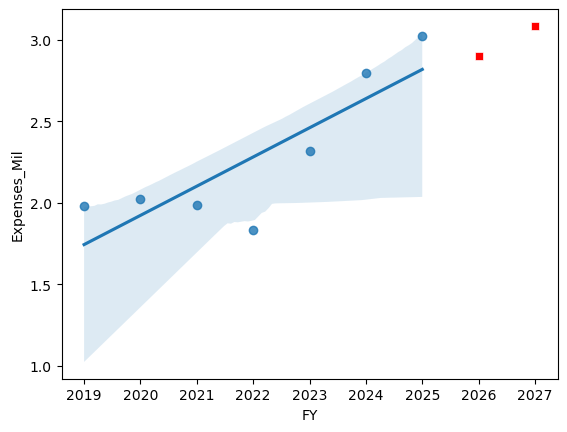

In [15]:
# Visualizing predicted and actual values
sns.scatterplot( x = 'FY', y = 'Typical', data = prediction_data, color = 'red', marker = 's')
sns.regplot( x = 'FY', y = 'Expenses_Mil', data = df) # <- Linear Regression

plt.show()

In [16]:
# Calculating prediction value ranges
prediction_data['Upper Range'] = round((prediction_data['Typical'] + rse) * mil,2)
prediction_data['Lower Range'] = round((prediction_data['Typical'] - rse) * mil,2)
prediction_data['Typical'] = round(prediction_data['Typical'] * mil,2)

prediction_data['Upper Range'] = prediction_data['Upper Range'].apply(lambda x: f'${x:,}')
prediction_data['Lower Range'] = prediction_data['Lower Range'].apply(lambda x: f'${x:,}')
prediction_data['Typical'] = prediction_data['Typical'].apply(lambda x: f'${x:,}')

prediction_data = prediction_data[['FY','Lower Range','Typical','Upper Range']]

print(prediction_data)

     FY    Lower Range        Typical    Upper Range
0  2026  $2,526,868.72  $2,901,352.61   $3,275,836.5
1  2027  $2,711,376.63  $3,085,860.52  $3,460,344.42
